# Описание проекта

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды, используя данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Технологический процесс

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

**1. Флотация**

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

**2. Очистка**

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

## Описание данных

Технологический процесс

- `Rougher feed` — исходное сырье

- `Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

  - Xanthate — ксантогенат (промотер, или активатор флотации);
  - Sulphate — сульфат (на данном производстве сульфид натрия);
  - Depressant — депрессант (силикат натрия).

- `Rougher process` (англ. «грубый процесс») — флотация

- `Rougher tails` — отвальные хвосты

- `Float banks` — флотационная установка

- `Cleaner process` — очистка

- `Rougher Au` — черновой концентрат золота

- `Final Au` — финальный концентрат золота

Параметры этапов

    air amount — объём воздуха
    fluid levels — уровень жидкости
    feed size — размер гранул сырья
    feed rate — скорость подачи

---

# Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings


from IPython.display import display
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from numpy.random import RandomState
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_validate, KFold

STATE = RandomState(17)
warnings.filterwarnings('ignore')

---

## Подготовка данных

In [2]:
try:
    train = pd.read_csv(r'C:\Users\vk\data_science\data\gold\gold_recovery_train_new.csv')
    test = pd.read_csv(r'C:\Users\vk\data_science\data\gold\gold_recovery_test_new.csv')
    full = pd.read_csv(r'C:\Users\vk\data_science\data\gold\gold_recovery_full_new.csv')
except:
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
data_list = [train, test, full]
for i in data_list:
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


None

- Выводим общую информацию о датафреймах, чтобы посмотреть на типы данных, заметить возможные пропуски, а также на кол-во строк и столбцов в каждом

In [4]:
for i in data_list:
    display(i.head(5))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
for i in data_list:
    print("Количество дубликатов:", i.duplicated().sum())
    print()
    print("Количество пропусков в столбце:")
    print(i.isna().sum())

Количество дубликатов: 0

Количество пропусков в столбце:
date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64
Количество дубликатов: 0

Количество пропусков в столбце:
date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner

In [6]:
test.replace(0, np.nan)
test.dropna(inplace=True)
train.replace(0, np.nan)
train.dropna(inplace=True)

In [7]:
print(test.isna().sum())
print(train.isna().sum())

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

- Подсчитываем количество дубликатов и пропусков
- В обучающей и тестовой выборке удаляем пропущенные значения

In [8]:
concentrate_au = train['rougher.output.concentrate_au']
feed_au = train['rougher.input.feed_au']
tail_au = train['rougher.output.tail_au']
input_recovery = train['rougher.output.recovery']
calculated_recovery = ((concentrate_au * (feed_au - tail_au)) / (feed_au * (concentrate_au - tail_au))) * 100
print('Абсолютная средняя ошибка =', mean_absolute_error(input_recovery, calculated_recovery))

Абсолютная средняя ошибка = 9.82970122149377e-15


- Высчитываем MAE(Абсолютная средняя ошибка), ее значение равно ~10
- Это значит, что нашим расчетам можно верить, так как MAE имеет малое отклонение

- В обучающей выборке столбцов было больше, чем в обучающей
- Их необходимо сравнять для дальнейшего анализа


В тестовой выборке отсуствуют признаки `rougher.output`, `rougher.calculation`, `final.output`, `primary_cleaner.output` и `secondary_cleaner.output`.
Эти данные получаются "в режиме реального времени", как результат технологического процесса.

In [9]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11017 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                11017 non-null  object 
 1   final.output.concentrate_ag                         11017 non-null  float64
 2   final.output.concentrate_pb                         11017 non-null  float64
 3   final.output.concentrate_sol                        11017 non-null  float64
 4   final.output.concentrate_au                         11017 non-null  float64
 5   final.output.recovery                               11017 non-null  float64
 6   final.output.tail_ag                                11017 non-null  float64
 7   final.output.tail_pb                                11017 non-null  float64
 8   final.output.tail_sol                               11017 non-null  float64


**Вывод:**
- Были изучены данные
- Удалены пропущенные значения в тестовой и обучающей выборках
- Сравняли количество столбцов в тестовой и обучающей выборках

---

## Анализ данных

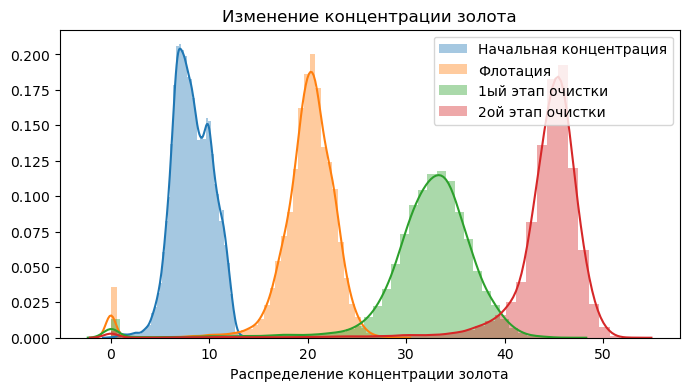

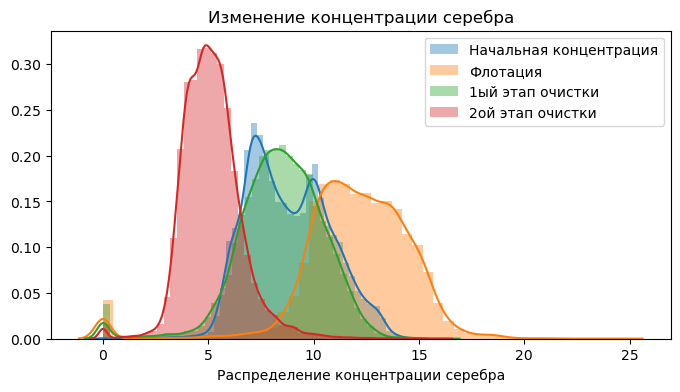

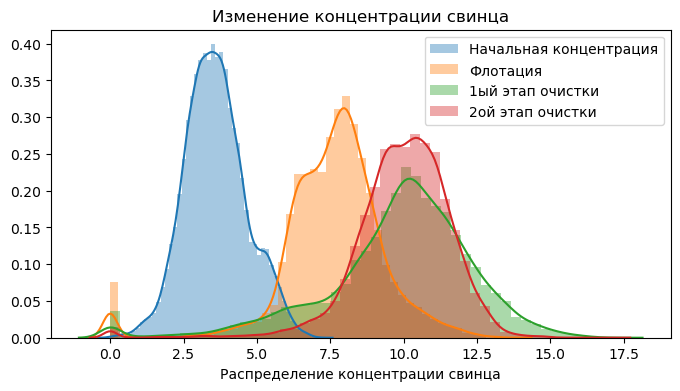

In [10]:
resources = [('au', 'золота'), ('ag', 'серебра'), ('pb', 'свинца')]

stages = [('rougher.input.feed_', 'Начальная концентрация'),
          ('rougher.output.concentrate_', 'Флотация'),
          ('primary_cleaner.output.concentrate_', '1ый этап очистки'),
          ('final.output.concentrate_', '2ой этап очистки')]

for i in resources:
    plt.figure(figsize=(8,4))
    for item in stages:
        ax = sns.distplot(full[item[0] + i[0]], label=item[1])
        plt.legend()
        _ = ax.set(xlabel='Распределение концeнтрации ' + i[1], 
                   title='Изменение концентрации ' + i[1],
                   ylabel='')
    plt.show()

- Построены графики изменения концентрации разных руд
- Наименьшую концентрацию после второго этапа очистки имеет золото
- Концентрация серебра  уменьшилась, а концентрация свинца увеличивалась. Скорее всего это связано с очищением золотой руды.

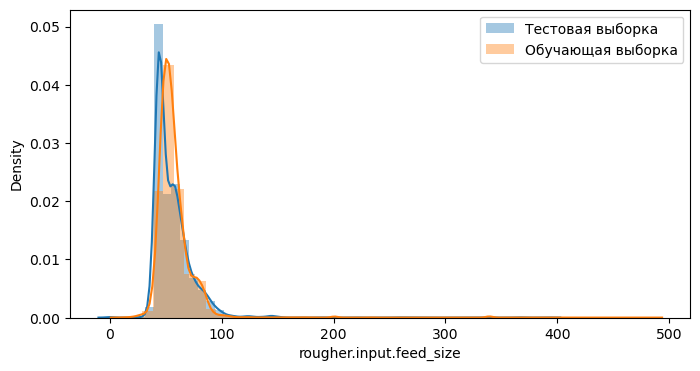

In [11]:
plt.figure(figsize=(8,4))
sns.distplot(test['rougher.input.feed_size'], label='Тестовая выборка')
sns.distplot(train['rougher.input.feed_size'], label='Обучающая выборка')
plt.legend()

- Графическое изображение распределения размеров гранул сырья на двух выборках (обучающей и тестовой)

Две выборки имеют нормальное распределение. Также у обоих выборок замечены выбросы после значения 100 из-за чего можно видеть длинную рыжую линию, которая стремится к значению 500. Если увеличить масштабность, то можно будет заметить и выбросы тестовой выборки.

**Вывод:** распределения похожи, если бы сильно отличались, то оценка модели была бы неправильной.

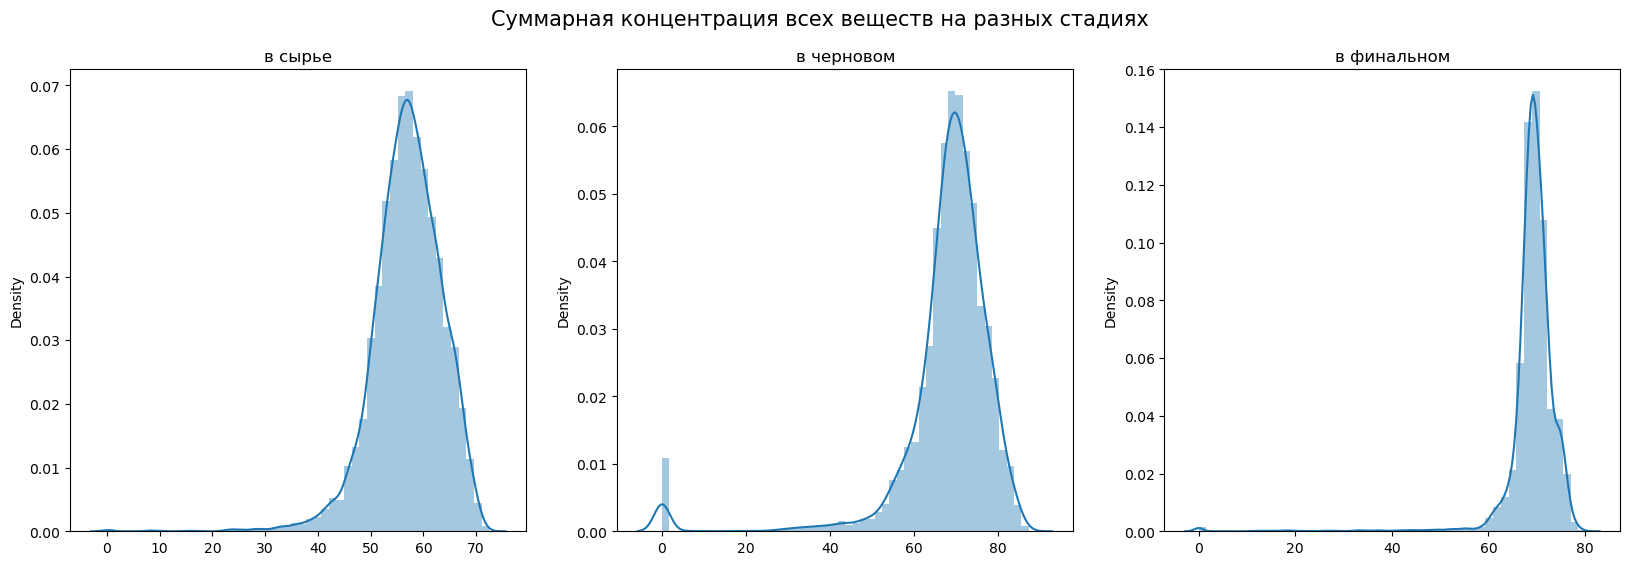

In [12]:
conc_stages = [('rougher.input.feed_', 'в сырье'),
               ('rougher.output.concentrate_', 'в черновом'),
               ('final.output.concentrate_', 'в финальном')]


fig, axs = plt.subplots(1, len(conc_stages), figsize=(20, 6))
fig.suptitle('Суммарная концентрация всех веществ на разных стадиях', fontsize=15)


for stage, ax in zip(conc_stages, axs):
    ax.set_title(stage[1])
    full_sum =  train[stage[0]+ 'ag'] + train[stage[0]+ 'au'] + train[stage[0]+ 'pb'] + train[stage[0]+ 'sol']

    sns.distplot(full_sum, ax=ax)   

plt.show()

- Графическое изображение суммарной концетрации веществ на 3 разных стадиях
- Заметно небольшое кол-во выбросов в черновой стадии и в финальной, однако их очень мало, поэтому можно не удалять их (сильно мешать они не будут)
- На финалькой стадии заметно, что концетрация веществ сильно уменьшилась

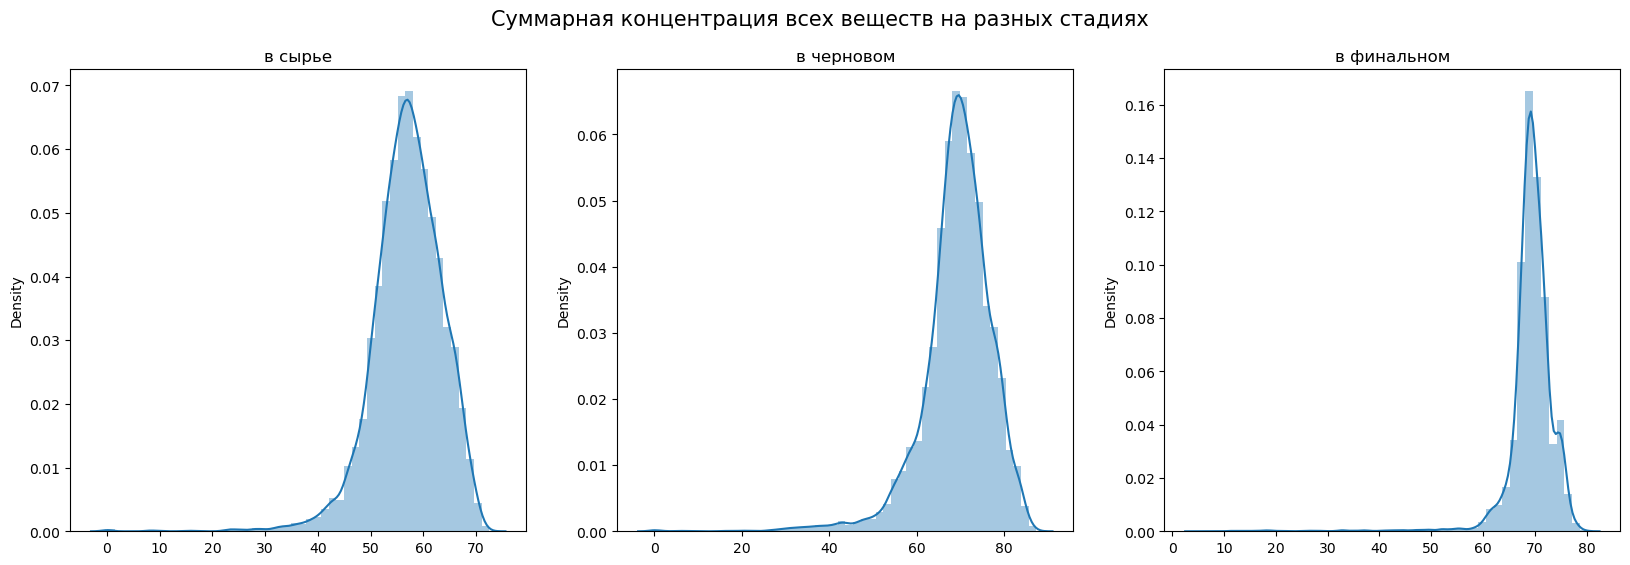

In [13]:
conc_stages = [('rougher.input.feed_', 'в сырье'),
               ('rougher.output.concentrate_', 'в черновом'),
               ('final.output.concentrate_', 'в финальном')]


fig, axs = plt.subplots(1, len(conc_stages), figsize=(20, 6))
fig.suptitle('Суммарная концентрация всех веществ на разных стадиях', fontsize=15)


for stage, ax in zip(conc_stages, axs):
    ax.set_title(stage[1])
    total =  train[stage[0]+ 'ag'] + train[stage[0]+ 'au'] + train[stage[0]+ 'pb'] + train[stage[0]+ 'sol']

    sns.distplot(total.replace(0,np.nan).dropna(), ax=ax) 
plt.show()


In [14]:
train.shape

(11017, 87)

## Модель

In [15]:
train = train[test.columns]

In [16]:
def smape(y_target, y_pred):
    return ((1/len(y_target)) * np.sum(2 * np.abs(y_target - y_pred) / (np.abs(y_target) + np.abs(y_pred)))) * 100

- Функция, которая расчитывает значение SMAPE (формула расчета получена от заказчика)

In [17]:
needed_target = full.loc[:,['date','rougher.output.recovery','final.output.recovery']]

In [18]:
train = train.merge(needed_target, on='date')
test = test.merge(needed_target, on='date')

In [19]:
test.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

In [20]:
x_train_r = train.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
x_test_r = test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)

y_train_r = train['rougher.output.recovery']
y_test_r = test['rougher.output.recovery']

x_train_f = train.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
x_test_f = test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)

y_train_f = train['final.output.recovery']
y_test_f = test['final.output.recovery']

- Подгатавливаем целевой признак и остальные признаки 
- Удаляем лишний столбец, который лишь будет мешать обучению моделей

In [21]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=120, random_state=STATE))
])





params = [
    {
        'model': [RandomForestRegressor(n_estimators=15, random_state=STATE)],
        'model__max_features': np.linspace(0.1, 1, 10)
    }, {
        'model': [LinearRegression()]
    }
]

- Для обучения и анализа будем использовать 2 модели: `Random Forest Regressor, Linear Regression`
- С помощью `GridSearchCV` подберем наиболее "удачные" параметры

In [22]:
smape_score = make_scorer(smape, greater_is_better=False)

- Подготовим значения SMAPE для подбора `GridSearchCV`, с помощью функции `make_scorer`

In [23]:
cv = KFold(n_splits=5, shuffle=False)
grid_r = GridSearchCV(pipe, param_grid=params, cv=cv, n_jobs=-1, scoring=smape_score)

- Проводим кросс-валидацию (с помощью `KFold`) и делим данные на 5 частей

In [24]:
%%time

grid_r.fit(x_train_r, y_train_r)

Wall time: 1min 27s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(n_estimators=120,
                                                              random_state=RandomState(MT19937) at 0x21F896FDA40))]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(max_features=0.1,
                                                          n_estimators=15,
                                                          random_state=RandomState(MT19937) at 0x21F896FDA40)],
                          'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                         {'model': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False))

- Запускаем подбор параметров

In [25]:
print('Лучшие параметры:', grid_r.best_params_)
print('Лучшее sMAPE значение:', -grid_r.best_score_)

Лучшие параметры: {'model': RandomForestRegressor(max_features=0.1, n_estimators=15,
                      random_state=RandomState(MT19937) at 0x21F896FDA40), 'model__max_features': 0.1}
Лучшее sMAPE значение: 11.425163195439524


In [26]:
grid_f = GridSearchCV(pipe, param_grid=params, cv=cv, n_jobs=-1, scoring=smape_score)

In [27]:
%%time

grid_f.fit(x_train_f, y_train_f)

Wall time: 1min 22s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(n_estimators=120,
                                                              random_state=RandomState(MT19937) at 0x21F896FDA40))]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(max_features=0.1,
                                                          n_estimators=15,
                                                          random_state=RandomState(MT19937) at 0x21F896FDA40)],
                          'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                         {'model': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False))

- Запускаем подбор параметров

In [28]:
print('Лучшие параметры:', grid_f.best_params_)
print('Лучшее sMAPE значение:', -grid_f.best_score_)

Лучшие параметры: {'model': LinearRegression()}
Лучшее sMAPE значение: 9.74608110619009


In [29]:
pipe_r = grid_r.best_estimator_

pipe_r.fit(x_train_r, y_train_r)
y_pred = pipe_r.predict(x_test_r)

smape_r = smape(full.loc[x_test_r.index, 'rougher.output.recovery'], y_pred)
print('Значение sMAPE(rougher):', smape_r)

Значение sMAPE(rougher): 13.103860215806327


- Подставляем лучшие параметры в модель и высчитываем sMAPE(rougher)

In [30]:
pipe_f = grid_f.best_estimator_
    
pipe_f.fit(x_train_f, y_train_f)
y_pred_f = pipe_f.predict(x_test_f)

smape_f = smape(full.loc[x_test_r.index, 'final.output.recovery'],y_pred_f)
print('Значение sMAPE(final):', smape_f)

Значение sMAPE(final): 12.410448582286284


- Подставляем лучшие параметры в модель и высчитываем sMAPE(final)

In [31]:
final_smape = 0.25 * smape_r + 0.75 * smape_f
print('Итоговое значение sMAPE:', final_smape)

Итоговое значение sMAPE: 12.583801490666294


- Высчитываем итоговое значение sMAPE

In [32]:
median_r = pd.Series(y_train_r.median(), index=y_test_r.index)
median_f = pd.Series(y_train_f.median(), index=y_test_f.index)

median_smape_r = smape(y_test_r, median_r)
median_smape_f = smape(y_test_f, median_f)

res = (median_smape_r*0.25) + (median_smape_f* 0.75)
print('median_smape_r:', median_smape_r)
print('median_smape_f:', median_smape_f)
print('Значение sMAPE для медианной модели:', res)

median_smape_r: 8.726191443253407
median_smape_f: 9.29642688803166
Значение sMAPE для медианной модели: 9.153868026837095


---

**Вывод:**

    1) Изучены и подготовлены данные
    2) Проведен исследовательский анализ данных
    3) Построены и обучены модели
    
Была написана функция для вычисления sMAPE. С помощью кросс-валидации и `GridSearchCV` были подобраны лучшие параметры для обучения моделей.